In [26]:
import random, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

import tool

In [27]:
asset_index = pd.read_csv("data/aidx_eod_prices.csv")

grouped_asset = asset_index.groupby("S_IRDCODE")
asset_dfs = {ird_code: group for ird_code, group in grouped_asset if len(group) >= 2000}
for ird_code, grouped_df in asset_dfs.items():
    grouped_df['TRADE_DT'] = pd.to_datetime(grouped_df['TRADE_DT'], format='%Y%m%d')
    grouped_df.sort_values(by='TRADE_DT', inplace=True)
    
unique_assets = list(asset_dfs.keys())
print(unique_assets)
print(len(unique_assets))

['000001.SH', '000002.SH', '000003.SH', '000004.SH', '000005.SH', '000006.SH', '000007.SH', '000008.SH', '000009.SH', '000010.SH', '000015.SH', '000016.SH', '000017.SH', '000018.SH', '000019.SH', '000020.SH', '000021.SH', '000025.SH', '000026.SH', '000027.SH', '000028.SH', '000029.SH', '000030.SH', '000031.SH', '000032.SH', '000033.SH', '000034.SH', '000035.SH', '000036.SH', '000037.SH', '000038.SH', '000039.SH', '000040.SH', '000041.SH', '000042.SH', '000043.SH', '000044.SH', '000045.SH', '000046.SH', '000047.SH', '000048.SH', '000049.SH', '000050.SH', '000051.SH', '000052.SH', '000053.SH', '000054.SH', '000055.SH', '000056.SH', '000057.SH', '000058.SH', '000059.SH', '000060.SH', '000062.SH', '000063.SH', '000064.SH', '000065.SH', '000066.SH', '000067.SH', '000068.SH', '000069.SH', '000070.SH', '000071.SH', '000072.SH', '000073.SH', '000074.SH', '000075.SH', '000076.SH', '000077.SH', '000078.SH', '000079.SH', '000090.SH', '000091.SH', '000092.SH', '000093.SH', '000094.SH', '000095.SH'

In [28]:
class GAmulti:
    def __init__(self, historical_data, future_data, model_type):
        self.historical_data = historical_data.copy()
        self.future_data = future_data.copy()
        self.model_type = model_type
        
    def evaluate(self, individual):
        ones_count = sum(individual)
        if ones_count > 20:
            ones_indices = [i for i, x in enumerate(individual) if x == 1]
            indices_to_zero = np.random.choice(ones_indices, size=(ones_count - 20), replace=False)
            for index in indices_to_zero:
                individual[index] = 0
        elif ones_count < 20:
            zero_indices = [i for i, x in enumerate(individual) if x == 0]
            indices_to_one = np.random.choice(zero_indices, size=(20 - ones_count), replace=False)
            for index in indices_to_one:
                individual[index] = 1
                
        selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
        
        historical_data = self.historical_data[self.historical_data.columns[self.historical_data.columns.isin(selected_assets)]]
        future_data = self.future_data[self.future_data.columns[self.future_data.columns.isin(selected_assets)]]
        
        n = len(selected_assets)
        index_min_weight = [0 for _ in range(n)]
        index_max_weight = [1 for _ in range(n)]
        weight_constraints = list(zip(index_min_weight, index_max_weight))
        
        predict, _, _ = tool.evaluate(historical_data, future_data, weight_constraints, self.model_type)
        expected_return, volatility, sharpe_ratio = predict
        
        return expected_return, sharpe_ratio, volatility
    
    def create_individual(self):
        n = len(unique_assets)
        individual = [0] * n

        indices = np.random.choice(n, 20, replace=False)
        for index in indices:
            individual[index] = 1

        np.random.shuffle(individual)

        return individual
    
    def main(self):
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0))
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initIterate, creator.Individual, self.create_individual)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        
        toolbox.register("evaluate", self.evaluate)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selNSGA2)
        
        def run_ga(pop_size, num_generations):
            pop = toolbox.population(n=pop_size)
            hof = tools.ParetoFront()
            logbook = tools.Logbook()
            stats = tools.Statistics(lambda ind: ind.fitness.values)

            stats.register("avg", np.mean, axis=0)
            stats.register("std", np.std, axis=0)
            stats.register("min", np.min, axis=0)
            stats.register("max", np.max, axis=0)
            
            pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof,  verbose=True)
            
            return pop, hof, stats, logbook
        
        population, pareto_front, stats, logbook = run_ga(50, 100)

        pareto_front = [ind for ind in pareto_front if not all(x == 0 for x in ind)]
        def get_calculations(individual):
            selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
            
            historical_data = self.historical_data[self.historical_data.columns[self.historical_data.columns.isin(selected_assets)]]
            future_data = self.future_data[self.future_data.columns[self.future_data.columns.isin(selected_assets)]]
            
            n = len(selected_assets)
            index_min_weight = [0 for _ in range(n)]
            index_max_weight = [1 for _ in range(n)]
            weight_constraints = list(zip(index_min_weight, index_max_weight))
            
            predict, actual, weight = tool.evaluate(historical_data, future_data, weight_constraints, self.model_type)
            
            return predict, actual, weight, selected_assets

        individual_predicts = {str(ind): get_calculations(ind)[0] for ind in pareto_front}
        individual_actuals = {str(ind): get_calculations(ind)[1] for ind in pareto_front}
        individual_weights = {str(ind): get_calculations(ind)[2] for ind in pareto_front}
        individual_selects = {str(ind): get_calculations(ind)[3] for ind in pareto_front}

        # Output
        for i, ind in enumerate(pareto_front):
            print(f"Pareto Front {i}")
            print(f"Selects: {individual_selects[str(ind)]}")
            print(f"Predicts: {individual_predicts[str(ind)]}")
            print(f"Actuals: {individual_actuals[str(ind)]}")
            print(f"Weights: {individual_weights[str(ind)]}")
            print("")
        
        return individual_predicts, individual_actuals, individual_weights, individual_selects

In [29]:
# randomly select assets
index_list = unique_assets
asset_index['TRADE_DT'] = pd.to_datetime(asset_index['TRADE_DT'], format='%Y%m%d')
asset_index.sort_values(by='TRADE_DT', inplace=True)
asset_index.set_index('TRADE_DT', inplace=True)
asset_index = asset_index.pivot(columns='S_IRDCODE', values='CLOSE').ffill()[index_list].dropna()

In [30]:
# historical_data = asset_index[:1000]
# future_data = asset_index[1000:]

# test = GAmulti(historical_data, future_data, 'RB-SLSQP')
# predicts, actuals, weights, selects = test.main()

# print(list(predicts.values()))
# print(list(actuals.values()))
# print(list(selects.values()))

In [45]:
def calvsEW(i, asset_index, actuals, selects):
    future_data = asset_index.copy()
    future_data = future_data[future_data.columns[future_data.columns.isin(selects[i])]]
    reality = tool.check([1 / len(future_data.columns) for _ in range(len(future_data.columns))], future_data, 0.02)
    actual = actuals[i]
    return actual[0] - reality[0], actual[1] / reality[1], actual[2] / reality[2]

def rebalance(asset_index, rebalance_day):
    max_return_result = []
    min_volatility_result = []
    custom_result = []
    
    for i in range(rebalance_day, len(asset_index), rebalance_day):
        if i+rebalance_day >= len(asset_index):
            break
        
        historical_data = asset_index[i-rebalance_day:i]
        future_data = asset_index[i:i+rebalance_day]
        
        test = GAmulti(historical_data, future_data, 'RB-SLSQP')
        predicts, actuals, weights, selects = test.main()
        predicts = list(predicts.values())
        actuals = list(actuals.values())
        selects = list(selects.values())
        
        # select max return
        max_return = float('-inf')
        max_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if ret > max_return and ret != np.inf:
                max_return = ret
                max_index = i
        max_ret_res = calvsEW(max_index, future_data, actuals, selects)
        max_return_result.append(max_ret_res)
        
        # select min volatility
        min_volatility = float('inf')
        min_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if vol < min_volatility:
                min_volatility = vol
                min_index = i
        min_vol_res = calvsEW(min_index, future_data, actuals, selects)
        min_volatility_result.append(min_vol_res)
        
        # select custom
        min_volatility = float('inf')
        cs_index = -1
        for i, (ret, vol, sharpe) in enumerate(predicts):
            if vol < min_volatility and ret >= 0:
                min_volatility = vol
                cs_index = i
        cs_res = calvsEW(cs_index, future_data, actuals, selects)
        custom_result.append(cs_res)
    
    return max_return_result, min_volatility_result, custom_result

In [46]:
ret, vol, cs = rebalance(asset_index, 210)

print(ret)
print(vol)
print(cs)

gen	nevals	avg                                           	std                                           	min                                              	max                                           
0  	10    	[1.71842545e+00 5.86633536e-03 2.16168190e+02]	[5.33495729e+00 1.89151121e-02 5.78380076e+01]	[-1.14590582e-01 -6.91939983e-04  1.22854226e+02]	[1.77230422e+01 6.26081189e-02 3.00373208e+02]
1  	8     	[1.72250611e+00 5.86422994e-03 2.15226341e+02]	[5.35657690e+00 1.89727580e-02 5.68381007e+01]	[-1.16177539e-01 -7.64470114e-04  1.42170368e+02]	[1.77919918e+01 6.27784115e-02 3.04331076e+02]
2  	8     	[1.70683655e+00 9.43137151e-03 2.11621259e+02]	[5.29801965e+00 2.95111727e-02 5.46887070e+01]	[-1.16177539e-01 -7.68700862e-04  1.50816211e+02]	[1.76006220e+01 9.79626918e-02 3.07459040e+02]
Pareto Front 0
Selects: ['000500USD01.CSI', '483029.CNI', '930848.CSI', '931056.CSI', '931150.CSI', 'CN2030.CNI', 'CN2408.CNI', 'CN2554.CNI', 'CN2677.CNI', 'CN6003.CNI', 'CN6004.CNI', 'h00839.

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                           	std                                           	min                                           	max                                           
0  	10    	[1.26418559e-01 9.34557408e-04 1.10261288e+02]	[4.05199006e-02 2.94956828e-04 3.31548663e+01]	[3.16209030e-02 2.65863452e-04 4.37100434e+01]	[1.93753614e-01 1.40675292e-03 1.84147861e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
1  	6     	[1.29308606e-01 9.32824040e-04 1.15610382e+02]	[4.14518639e-02 3.22432250e-04 3.82429965e+01]	[3.05819313e-02 2.41603423e-04 4.37987641e+01]	[1.97771807e-01 1.40675292e-03 1.86432215e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
2  	7     	[1.18671487e-01 8.44792180e-04 1.12373968e+02]	[4.72117511e-02 3.31990040e-04 3.73402618e+01]	[3.05819313e-02 2.41603423e-04 4.37987641e+01]	[1.97771807e-01 1.50359984e-03 1.86432215e+02]
NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Pareto Front 0
Selects: ['000816.CSI', '000950.CSI', '399401.SZ', '480004.CNI', '489001.CNI', '930692.CSI', '931160.CSI', '931535USD00.CSI', '950107.CSI', '950218CNY01.CSI', 'L01606.CSI', 'L11237.CSI', 'h20254.CSI', 'h20673.CSI', 'h20688.CSI', 'h21158.CSI', 'h30024.CSI', 'h30082.CSI', 'h30562.CSI', 'n21387.CSI']
Predicts: (0.19777180717790177, 186.43221522910747, 0.0009535466118848458)
Actuals: (0.11910553834880927, 270.53682997629136, 0.0003663291920641431)
Weights: [0.03662054 0.03932562 0.0344024  0.03445176 0.03069809 0.04139891
 0.03766865 0.18292674 0.03931388 0.03979262 0.06820706 0.06522639
 0.04030734 0.03572912 0.04462184 0.03490373 0.09905962 0.03097798
 0.03225824 0.03210947]

Pareto Front 1
Selects: ['000816.CSI', '000950.CSI', '399401.SZ', '480004.CNI', '489001.CNI', '930692.CSI', '931160.CSI', '931535USD00.CSI', '950107.CSI', '950218CNY01.CSI', 'L01606.CSI', 'L11237.CSI', 'h00300.CSI', 'h20254.CSI', 'h20673.CSI', 'h20688.CSI', 'h21158.CSI', 'h30024.CSI', 'h30082.CSI', 'n

c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
gen	nevals	avg                                              	std                                           	min                                              	max                                              
0  	10    	[-1.39125882e-01 -3.88123429e-04  4.25993573e+02]	[3.76174249e-02 1.07580721e-04 9.04217340e+01]	[-2.00622862e-01 -5.77544971e-04  3.17988385e+02]	[-8.55207242e-02 -2.01325719e-04  5.69043219e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
1  	6     	[-1.33095974e-01 -3.71393738e-04  4.21758325e+02]	[3.43958462e-02 9.49521170e-05 7.00693944e+01]	[-2.00622862e-01 -5.11008111e-04  3.17988385e+02]	[-8.55207242e-02 -2.41271989e-04  5.63913503e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


NaN or inf values found in y. y must contains only finite values.
RB-SLSQP model fails!
2  	8     	[-1.33021077e-01 -3.72758451e-04  4.23043475e+02]	[4.15937910e-02 1.01903482e-04 1.08866135e+02]	[-2.00130112e-01 -5.11008111e-04  3.05723429e+02]	[-5.92889230e-02 -2.24734887e-04  6.14562464e+02]


c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Tool\Python3\lib\site-packages\arch\univariate\base.py:766: Convergen

Pareto Front 0
Selects: ['399003.SZ', '930651.CSI', '930797.CSI', '930899.CSI', '930924.CSI', '931100.CSI', '931268.CSI', '931673CNY01.CSI', '931734CNY01.CSI', '980023.CNI', 'CN2404.CNI', 'CN5062.CNI', 'CN6099.CNI', 'L11162.CSI', 'h00060.SH', 'h00138.SH', 'h01121.CSI', 'h20564.CSI', 'h21031.CSI', 'h30202.CSI']
Predicts: (-0.05928892301162605, 305.7234292531799, -0.0002593485334287684)
Actuals: (0.022257730269302344, 161.8598605380632, 1.3948673017492269e-05)
Weights: [0.0200126  0.03398638 0.02146151 0.05089977 0.01434716 0.02563684
 0.01989577 0.03033948 0.02806302 0.01785297 0.02285213 0.51334708
 0.03070083 0.03298124 0.01928418 0.02135475 0.023793   0.01918233
 0.02305842 0.03095054]

Pareto Front 1
Selects: ['399003.SZ', '930651.CSI', '930797.CSI', '930899.CSI', '930924.CSI', '931100.CSI', '931268.CSI', '931673CNY01.CSI', '931734CNY01.CSI', '980023.CNI', 'CN2404.CNI', 'CN5062.CNI', 'CN6099.CNI', 'L11232.CSI', 'h00815.CSI', 'h00945.CSI', 'h20184.CSI', 'h20564.CSI', 'h21031.CSI', 'h

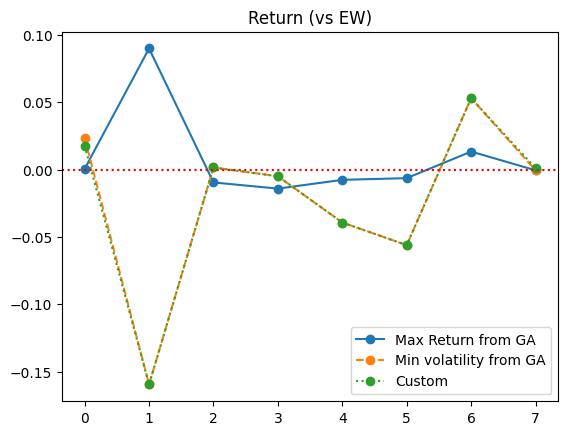

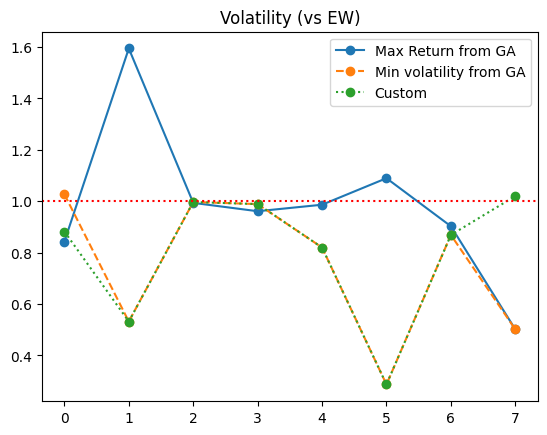

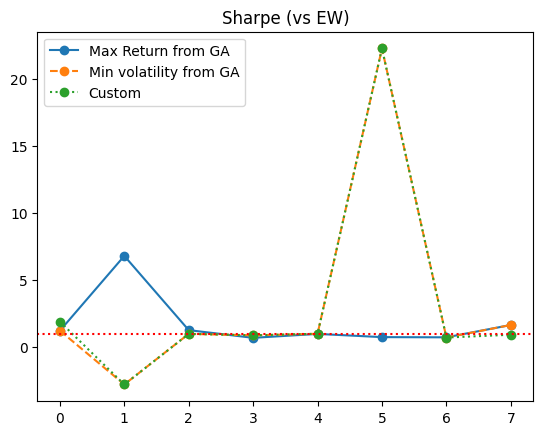

In [48]:
def extract_element(lists, element_index):
    return [[t[element_index] for t in lst] for lst in lists]

a_values = extract_element([ret, vol, cs], 0)
b_values = extract_element([ret, vol, cs], 1)
c_values = extract_element([ret, vol, cs], 2)

# Plotting function
def plot_lines(values, title, labels, benchmark_y):
    line_styles = ['-', '--', ':']
    plt.figure()
    i = 0
    for val, label in zip(values, labels):
        plt.plot(val, label=label, linestyle = line_styles[i], marker='o')
        i += 1
    plt.title(title)
    plt.axhline(y=benchmark_y, color='red', linestyle=':')
    plt.legend()
    plt.show()

line_labels = ['Max Return from GA', 'Min volatility from GA', 'Custom']

# Plotting
plot_lines(a_values, 'Return (vs EW)', line_labels, 0)
plot_lines(b_values, 'Volatility (vs EW)', line_labels, 1)
plot_lines(c_values, 'Sharpe (vs EW)', line_labels, 1)